In [9]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import celltypist
from celltypist import models
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=150)

# Import raw files

In [10]:
inpath="/home/lugli/spuccio/Projects/SP039/FileH5AD_input/"

In [11]:
ctrl085_L = sc.read(inpath+"ctrl085_L.h5ad")
ctrl086_1 = sc.read(inpath+"ctrl086_1.h5ad")
ctrl086_2 = sc.read(inpath+"ctrl086_2.h5ad")
ctrl099_21 = sc.read(inpath+"ctrl099_22.h5ad")
ctrl12 = sc.read(inpath+"ctrl12.h5ad")

In [25]:
ctrl086_1.obs['Sample']

ctrl086_1-0       Patient60
ctrl086_1-1       Patient60
ctrl086_1-2       Patient60
ctrl086_1-3       Patient60
ctrl086_1-4       Patient60
                    ...    
ctrl086_1-1742    Patient60
ctrl086_1-1743    Patient60
ctrl086_1-1744    Patient60
ctrl086_1-1745    Patient60
ctrl086_1-1746    Patient60
Name: Sample, Length: 1747, dtype: object

# Read Metadata

In [12]:
metadata = pd.read_excel('Metadata2.xlsx')

In [13]:
metadata['Sample'] =   [ 'Patient' + str(col) for col in metadata.Sample]

In [20]:
metadata.loc[metadata['Cohort']=="PMID35084939"]

SampleID       GEO_RNA        Cohort    Type       Subtype Diagnosis  \
58    ctrl085_L  NotAvailable  PMID35084939  Normal  NotAvailable    Normal   
59    ctrl086_1  NotAvailable  PMID35084939  Normal  NotAvailable    Normal   
60   ctrl099_21  NotAvailable  PMID35084939  Normal  NotAvailable    Normal   
61       ctrl12  NotAvailable  PMID35084939  Normal  NotAvailable    Normal   
121  ctrl099_22  NotAvailable  PMID35084939  Normal  NotAvailable    Normal   

      Grade      Location IDH1_Status EGFR_Status          MGMT  CellCount  \
58   Normal  NotAvailable      Normal      Normal  NotAvailable      936.0   
59   Normal  NotAvailable      Normal      Normal  NotAvailable     3498.0   
60   Normal  NotAvailable      Normal      Normal  NotAvailable     3086.0   
61   Normal  NotAvailable      Normal      Normal  NotAvailable      300.0   
121  Normal  NotAvailable      Normal      Normal  NotAvailable     6191.0   

         Sample           Sex           Age Sorted           MET  
58    Patient59  NotAvailable  NotAvailable   CD45  NotAvailable  
59    Patient60  NotAvailable  NotAvailable   CD45  NotAvailable  
60    Patient61  NotAvailable  NotAvailable   CD45  NotAvailable  
61    Patient62  NotAvailable  NotAvailable   CD45  NotAvailable  
121  Patient122  NotAvailable  NotAvailable   CD45  NotAvailable

# Fix Metadata 

In [15]:
ctrl085_L = sc.read(inpath+"ctrl085_L.h5ad")
ctrl086_1 = sc.read(inpath+"ctrl086_1.h5ad")
ctrl086_2 = sc.read(inpath+"ctrl086_2.h5ad")
ctrl099_21 = sc.read(inpath+"ctrl099_22.h5ad")
ctrl12 = sc.read(inpath+"ctrl12.h5ad")

In [27]:
ctrl086_1 = ctrl086_1.concatenate(ctrl086_2,
                         index_unique=None)

In [28]:
tmp1 = metadata.loc[metadata['SampleID'] == "ctrl085_L"].loc[metadata.loc[metadata['SampleID'] == "ctrl085_L"].index.repeat(ctrl085_L.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "ctrl085_L-" + tmp1.index.astype(str),inplace=True) 
ctrl085_L.obs = tmp1


In [29]:
tmp1 = metadata.loc[metadata['SampleID'] == "ctrl086_1"].loc[metadata.loc[metadata['SampleID'] == "ctrl086_1"].index.repeat(ctrl086_1.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "ctrl086_1-" + tmp1.index.astype(str),inplace=True) 
ctrl086_1.obs = tmp1


In [30]:
tmp1 = metadata.loc[metadata['SampleID'] == "ctrl099_21"].loc[metadata.loc[metadata['SampleID'] == "ctrl099_21"].index.repeat(ctrl099_21.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "ctrl099_21-" + tmp1.index.astype(str),inplace=True) 
ctrl099_21.obs = tmp1


In [31]:
tmp1 = metadata.loc[metadata['SampleID'] == "ctrl12"].loc[metadata.loc[metadata['SampleID'] == "ctrl12"].index.repeat(ctrl12.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "ctrl12-" + tmp1.index.astype(str),inplace=True) 
ctrl12.obs = tmp1


# Concatenate 

In [32]:
ctrl085_L.var_names_make_unique()
ctrl086_1.var_names_make_unique()
ctrl099_21.var_names_make_unique()
ctrl12.var_names_make_unique()

In [33]:
adata = ctrl085_L.concatenate(ctrl086_1,ctrl099_21,ctrl12,
                         index_unique=None)

In [34]:
del(ctrl085_L,ctrl086_1,ctrl099_21,ctrl12)


In [35]:
print(adata.obs['SampleID'].value_counts())
adata

ctrl099_21    6191
ctrl086_1     3498
ctrl085_L      936
ctrl12         300
Name: SampleID, dtype: int64


AnnData object with n_obs × n_vars = 10925 × 39974
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch'

In [36]:
adata.layers['raw'] = adata.X 

# Calculate QC

In [37]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [38]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [39]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [40]:
adata

AnnData object with n_obs × n_vars = 10925 × 39974
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw'

# Plot QC

... storing 'SampleID' as categorical
... storing 'GEO_RNA' as categorical
... storing 'Cohort' as categorical
... storing 'Type' as categorical
... storing 'Subtype' as categorical
... storing 'Diagnosis' as categorical
... storing 'Grade' as categorical
... storing 'Location' as categorical
... storing 'IDH1_Status' as categorical
... storing 'EGFR_Status' as categorical
... storing 'MGMT' as categorical
... storing 'Sample' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Sorted' as categorical
... storing 'MET' as categorical


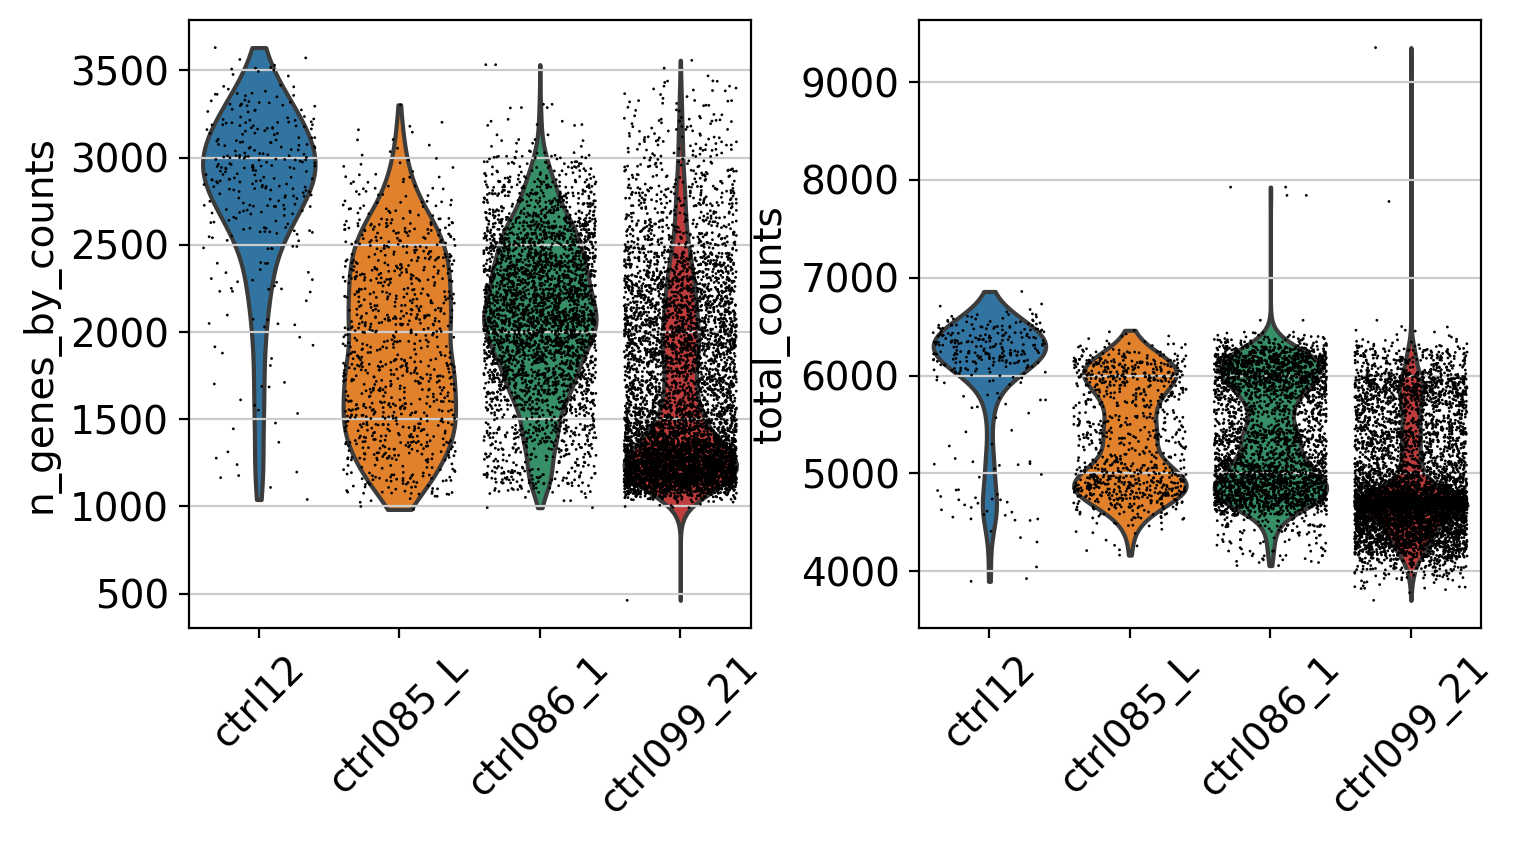

In [41]:
sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

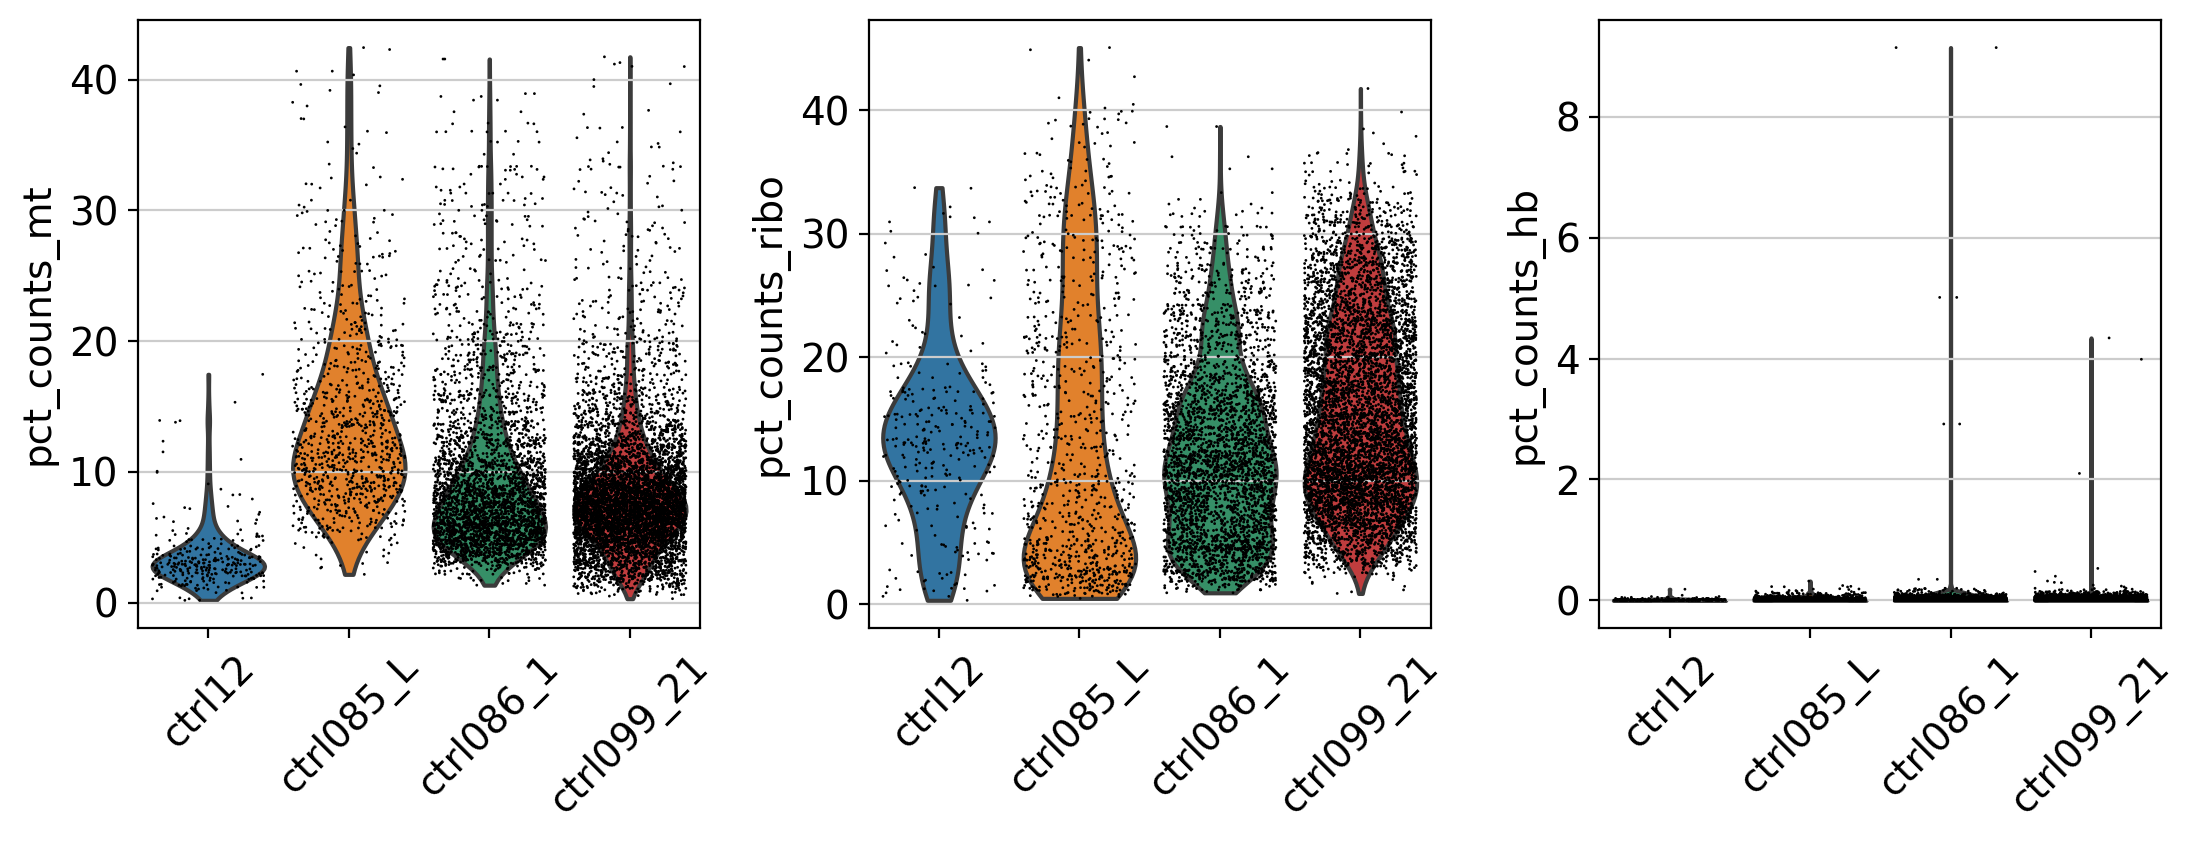

In [42]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

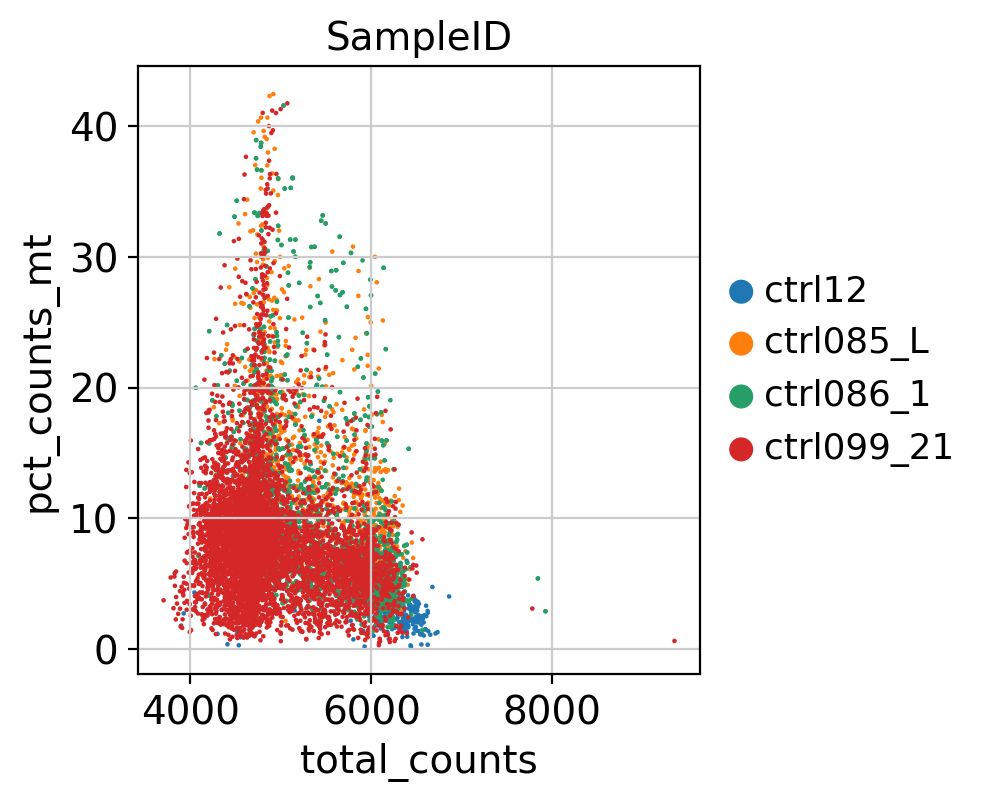

In [43]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="SampleID")

# Filtering

In [44]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

10925 31581


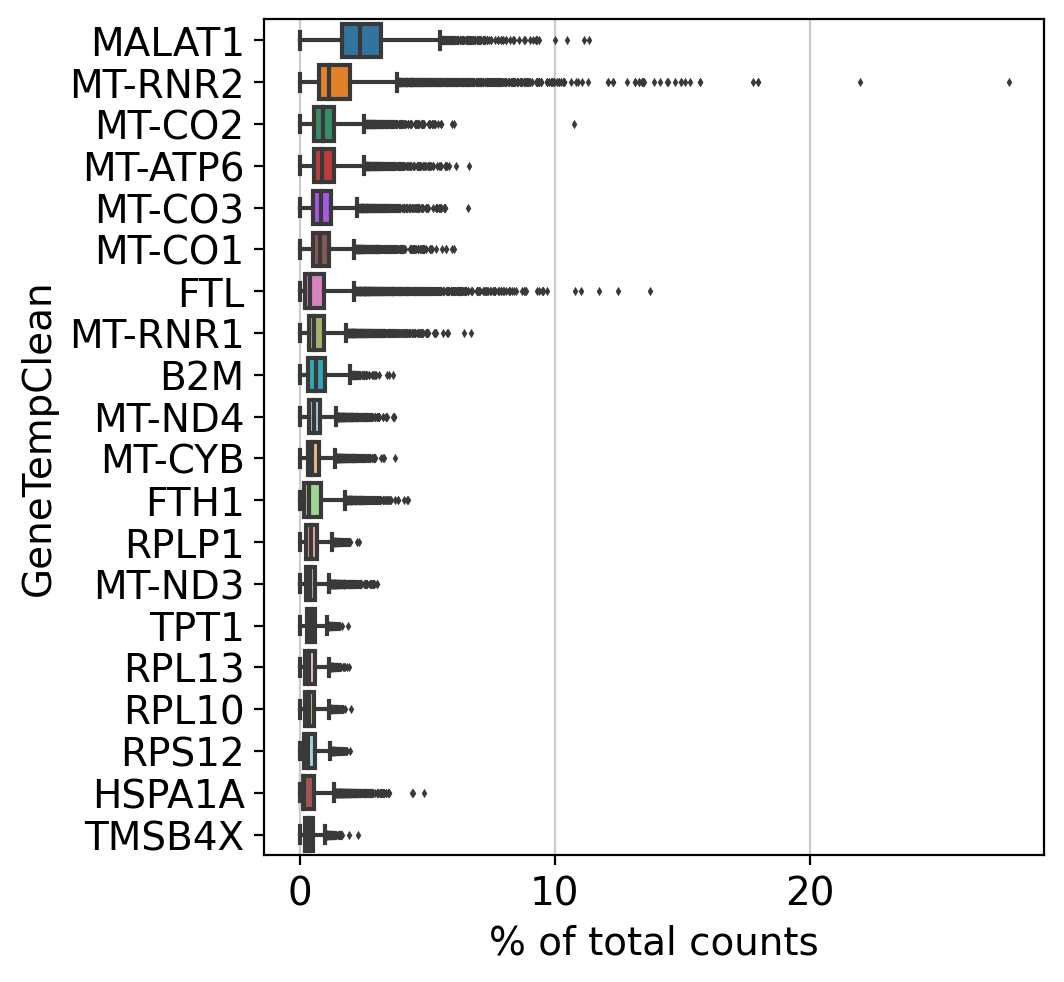

In [45]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Mito/Ribo filtering

In [46]:
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 1, :]
adata = adata[adata.obs['pct_counts_hb'] < 2, :]
print("Remaining cells %d"%adata.n_obs)

Remaining cells 10273


# Plot filtered QC

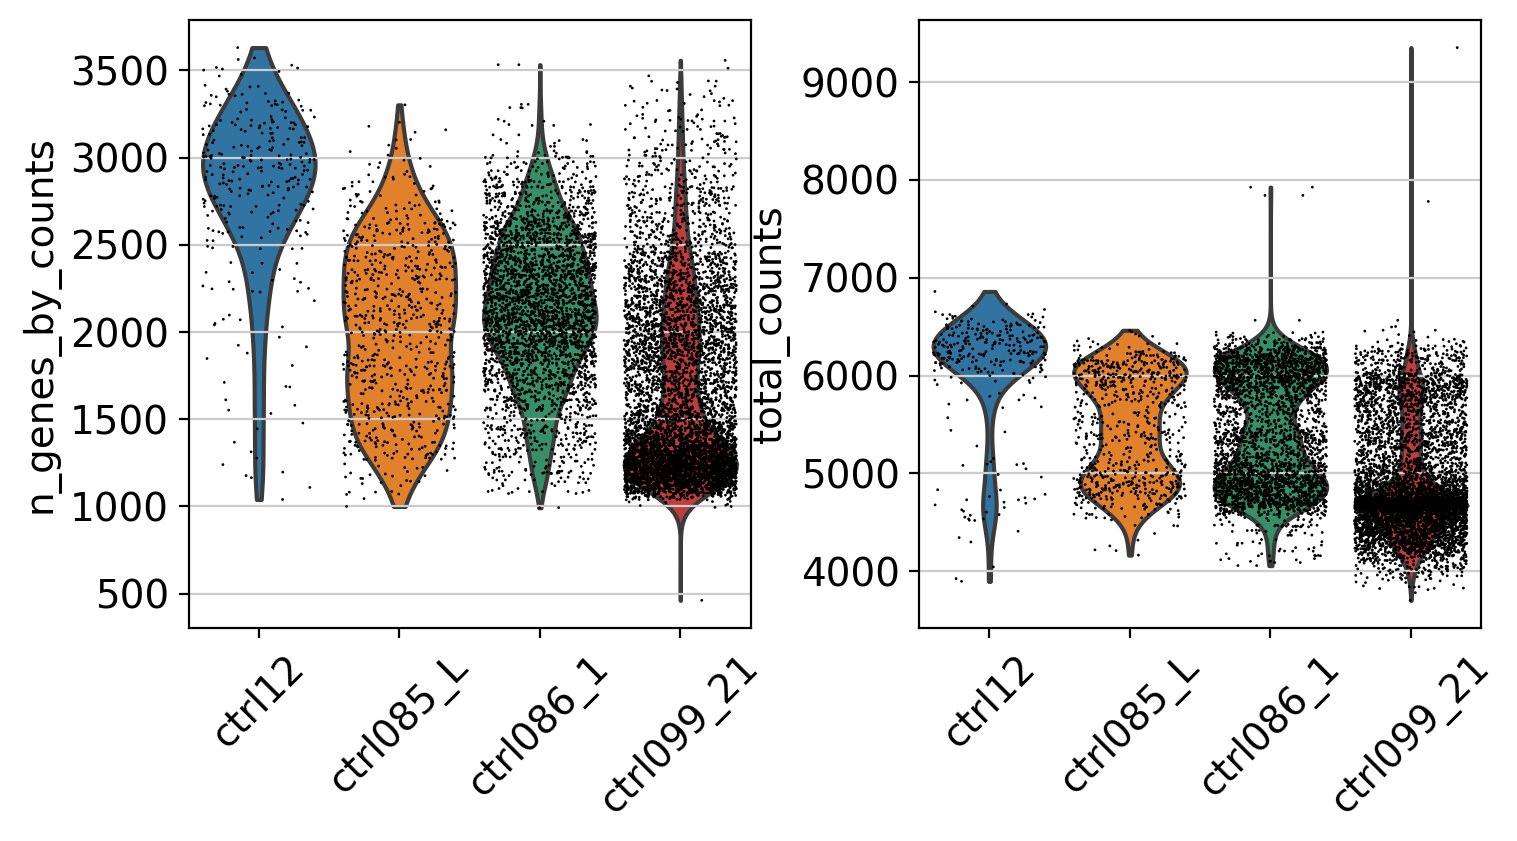

In [47]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

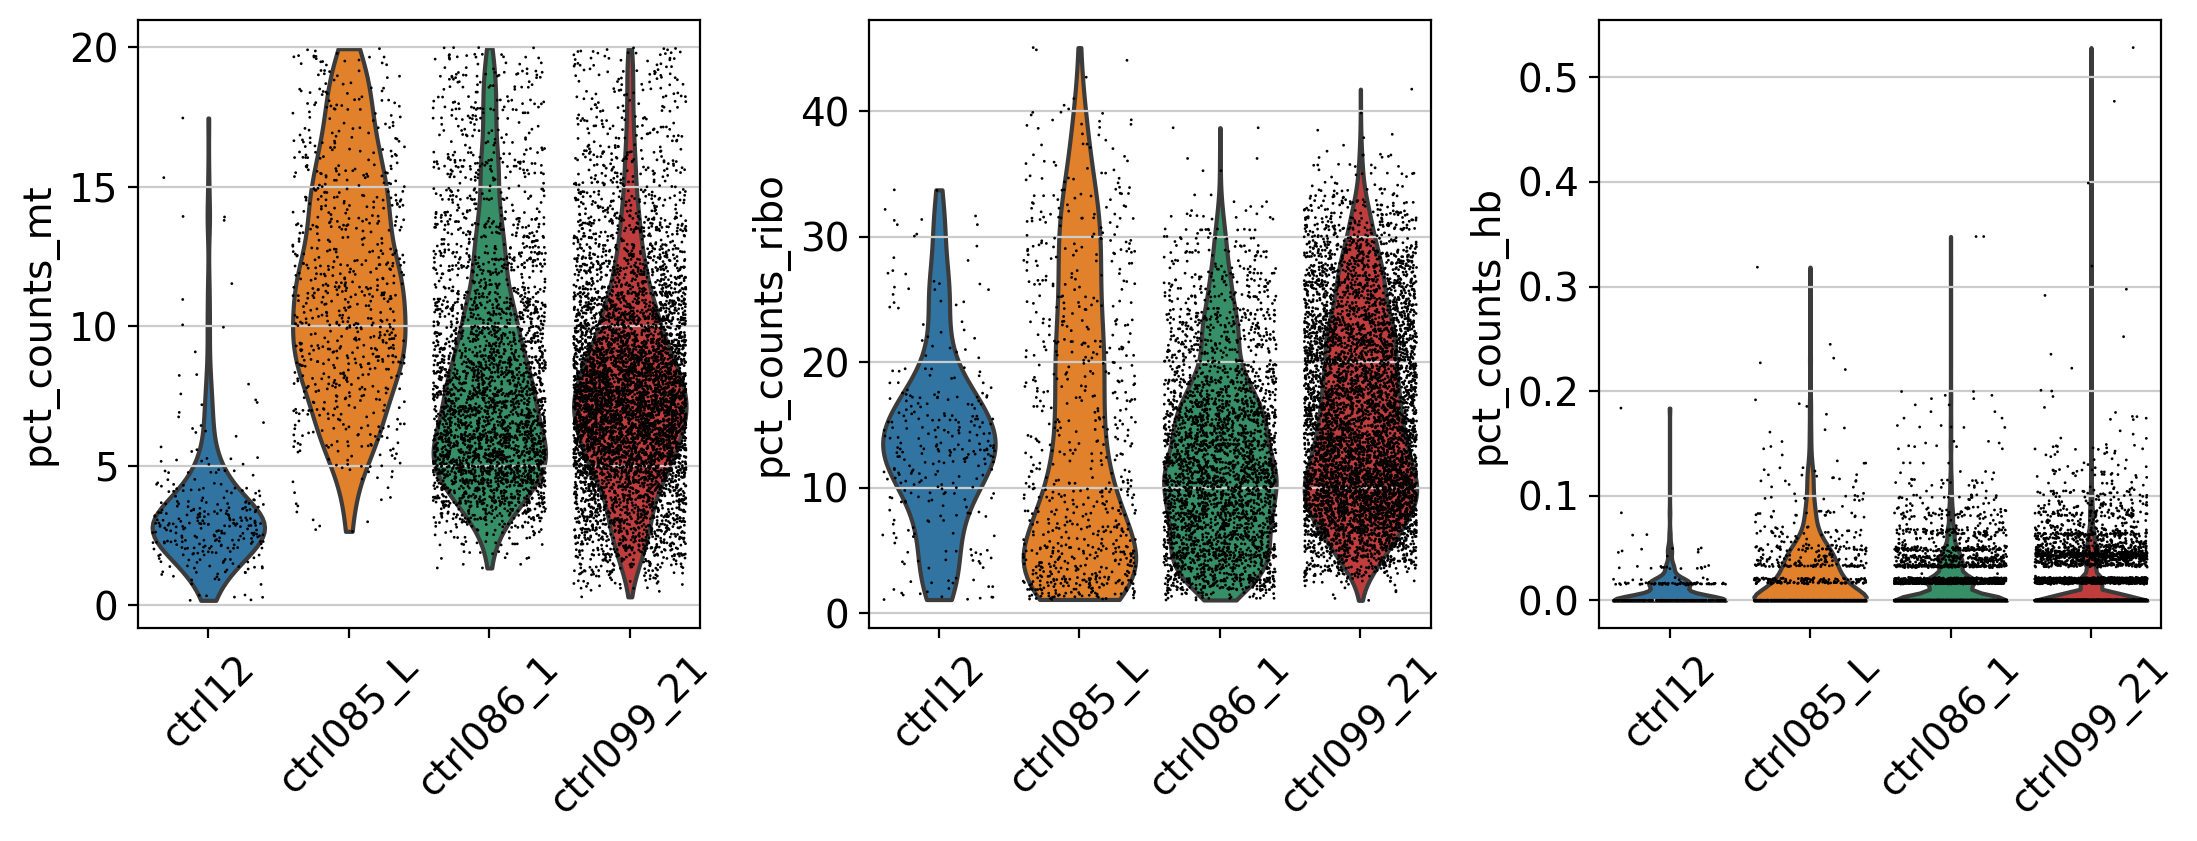

In [48]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

# Filter genes

In [49]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [50]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [51]:
adata = adata[:, ~mito_gene_indicator]

In [52]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
ribo_genes = adata.var_names.str.startswith(("RPL","RPS"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(ribo_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

10273 31566
10273 31134


# Calculate cell-cycle scores

In [53]:
cell_cycle_genes = [x.strip() for x in open('/home/lugli/spuccio/Projects/SP035_TregIntegration/Analysis/regev_lab_cell_cycle_genes_homo.txt')]
print(len(cell_cycle_genes))
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

90
90


In [54]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


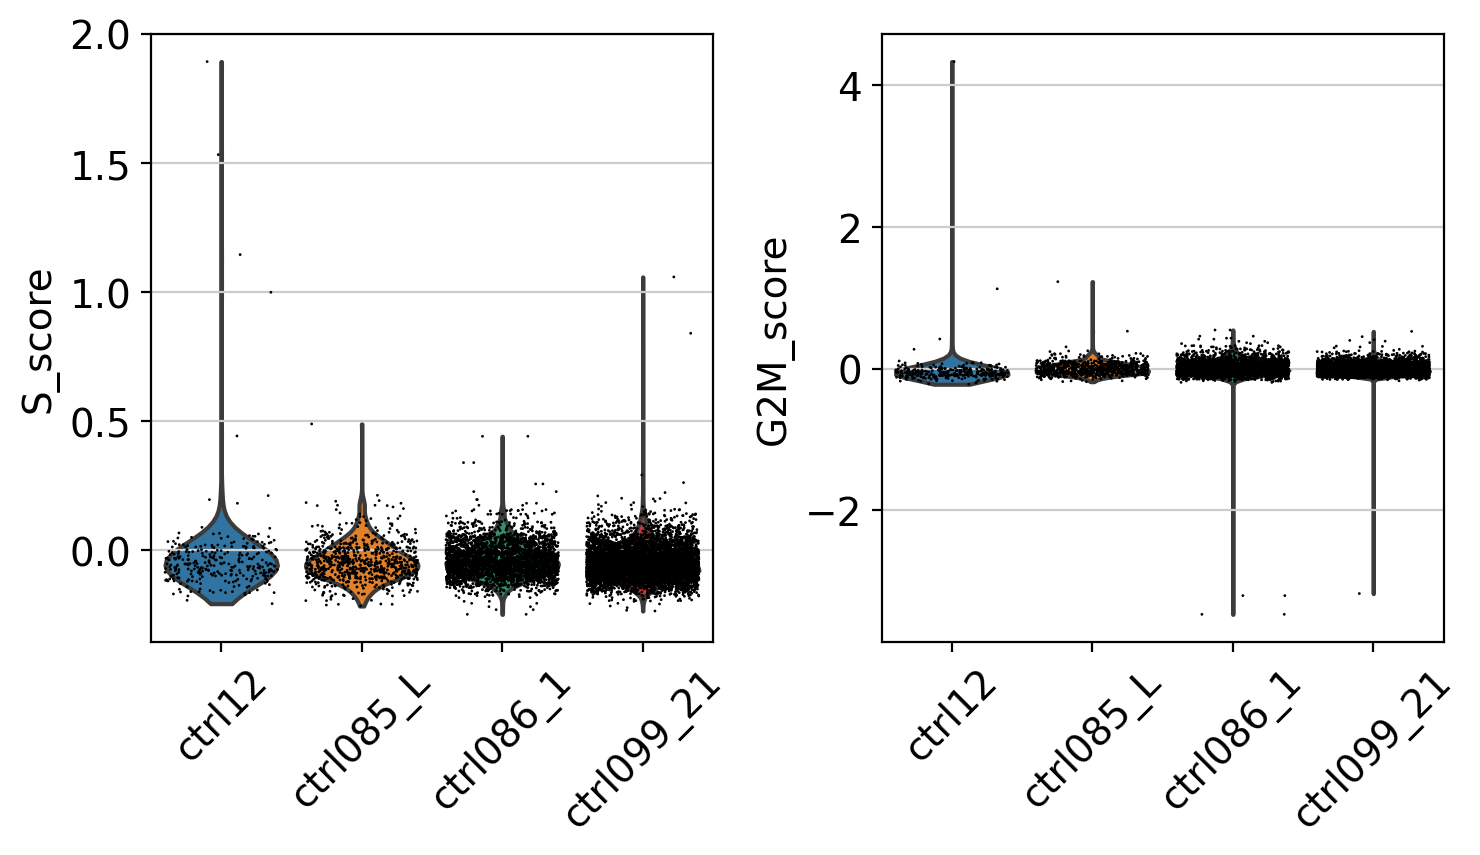

In [55]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'SampleID', rotation=45)

# Predict doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 48.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.1%
Elapsed time: 11.6 seconds


53

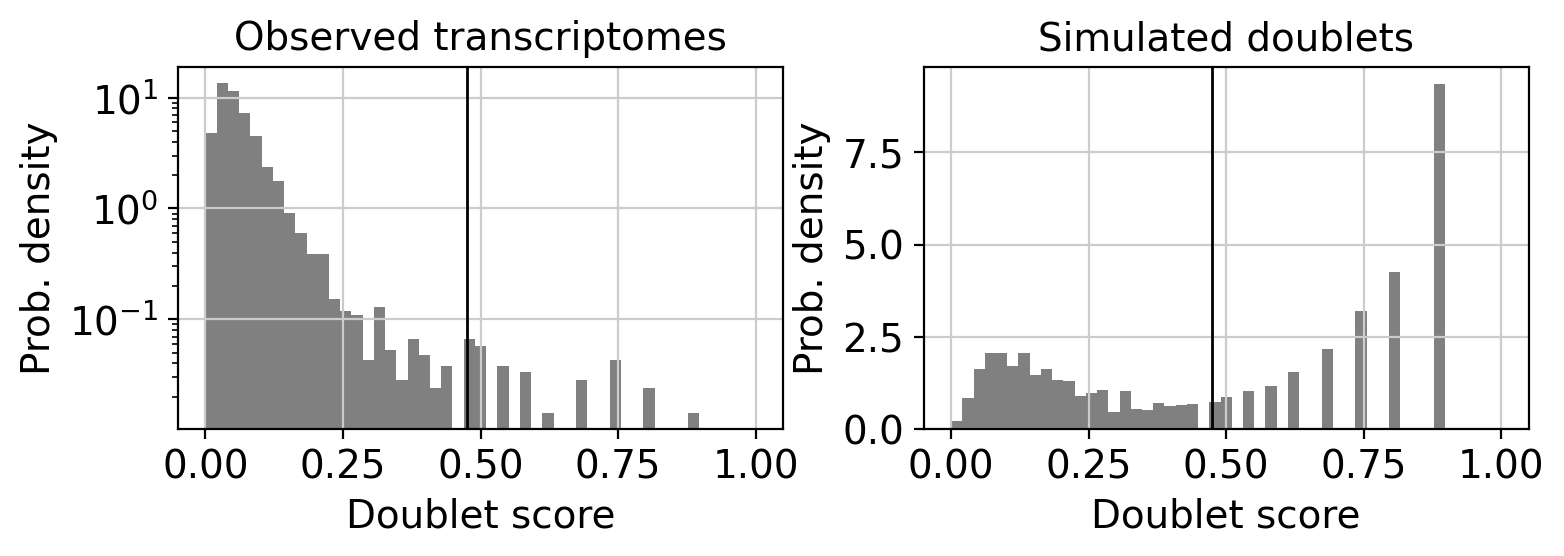

In [56]:
scrub = scr.Scrublet(adata.layers['raw'])
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [57]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


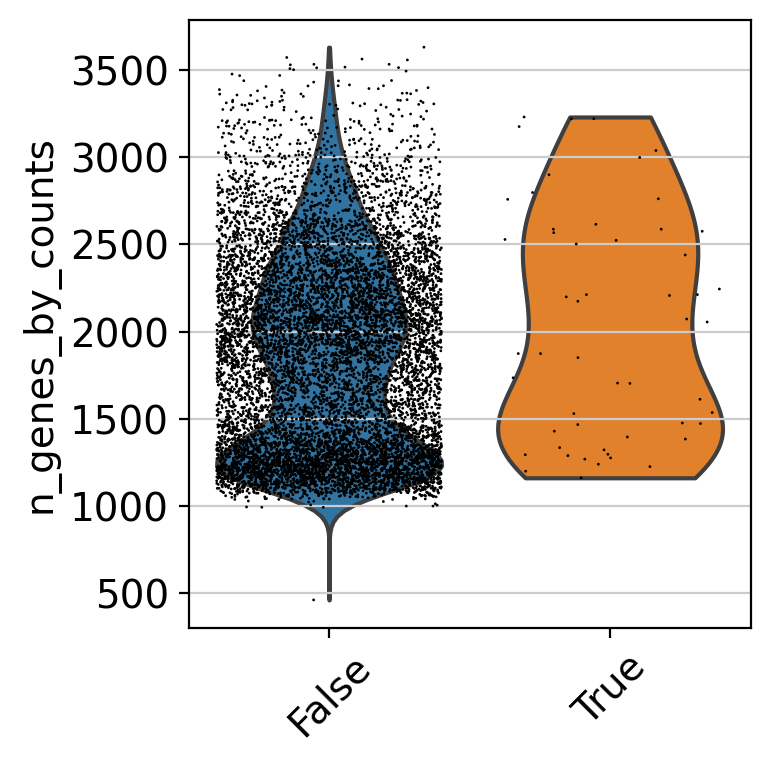

In [58]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'doublet_info', rotation=45)

In [59]:
adata = adata[adata.obs['doublet_info'] == "False",:]

# Processing 

In [60]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
# save normalized counts in raw slot.
adata.raw = adata
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata.layers['cpm'] = adata.X
# logaritmize
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Filter higly variable genes
#adata.raw = adata

# scale
#sc.pp.scale(adata)

# Celltypist classification

In [61]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [62]:
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [63]:
sce.pp.harmony_integrate(adata, ['SampleID'])

2022-06-13 23:39:09,896 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2022-06-13 23:39:11,368 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2022-06-13 23:39:12,832 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2022-06-13 23:39:14,303 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2022-06-13 23:39:15,761 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2022-06-13 23:39:17,240 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2022-06-13 23:39:18,515 - harmonypy - INFO - Iteration 7 of 10
Iteration 7 of 10
2022-06-13 23:39:19,992 - harmonypy - INFO - Converged after 7 iterations
Converged after 7 iterations


In [64]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')

In [65]:
sc.tl.umap(adata)

In [66]:
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']

In [67]:
adata

AnnData object with n_obs × n_vars = 10220 × 31134
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 'distances', 'connectivities'

In [68]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 13
📂 Storing models in /home/lugli/spuccio/.celltypist/data/models
💾 Downloading model [1/13]: Immune_All_Low.pkl
💾 Downloading model [2/13]: Immune_All_High.pkl
💾 Downloading model [3/13]: Immune_All_PIP.pkl
💾 Downloading model [4/13]: Immune_All_AddPIP.pkl
💾 Downloading model [5/13]: COVID19_Immune_Landscape.pkl
💾 Downloading model [6/13]: Cells_Fetal_Lung.pkl
💾 Downloading model [7/13]: Cells_Intestinal_Tract.pkl
💾 Downloading model [8/13]: Cells_Lung_Airway.pkl
💾 Downloading model [9/13]: Developing_Mouse_Brain.pkl
💾 Downloading model [10/13]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [11/13]: Human_Lung_Atlas.pkl
💾 Downloading model [12/13]: Nuclei_Lung_Airway.pkl
💾 Downloading model [13/13]: Pan_Fetal_Human.pkl


In [69]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [70]:
predictionsHigh = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 10220 cells and 31134 genes
🔗 Matching reference genes in the model
🧬 2885 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [71]:
#adata.obs['CellCount']= adata.obs['CellCount'].astype(int)

In [72]:
adata.obs['Sample'].value_counts()

Patient61    5945
Patient60    3223
Patient59     756
Patient62     296
Name: Sample, dtype: int64

In [74]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_I_Winkler.h5ad")

In [75]:
predictionsHigh.to_adata()

AnnData object with n_obs × n_vars = 10220 × 31134
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 

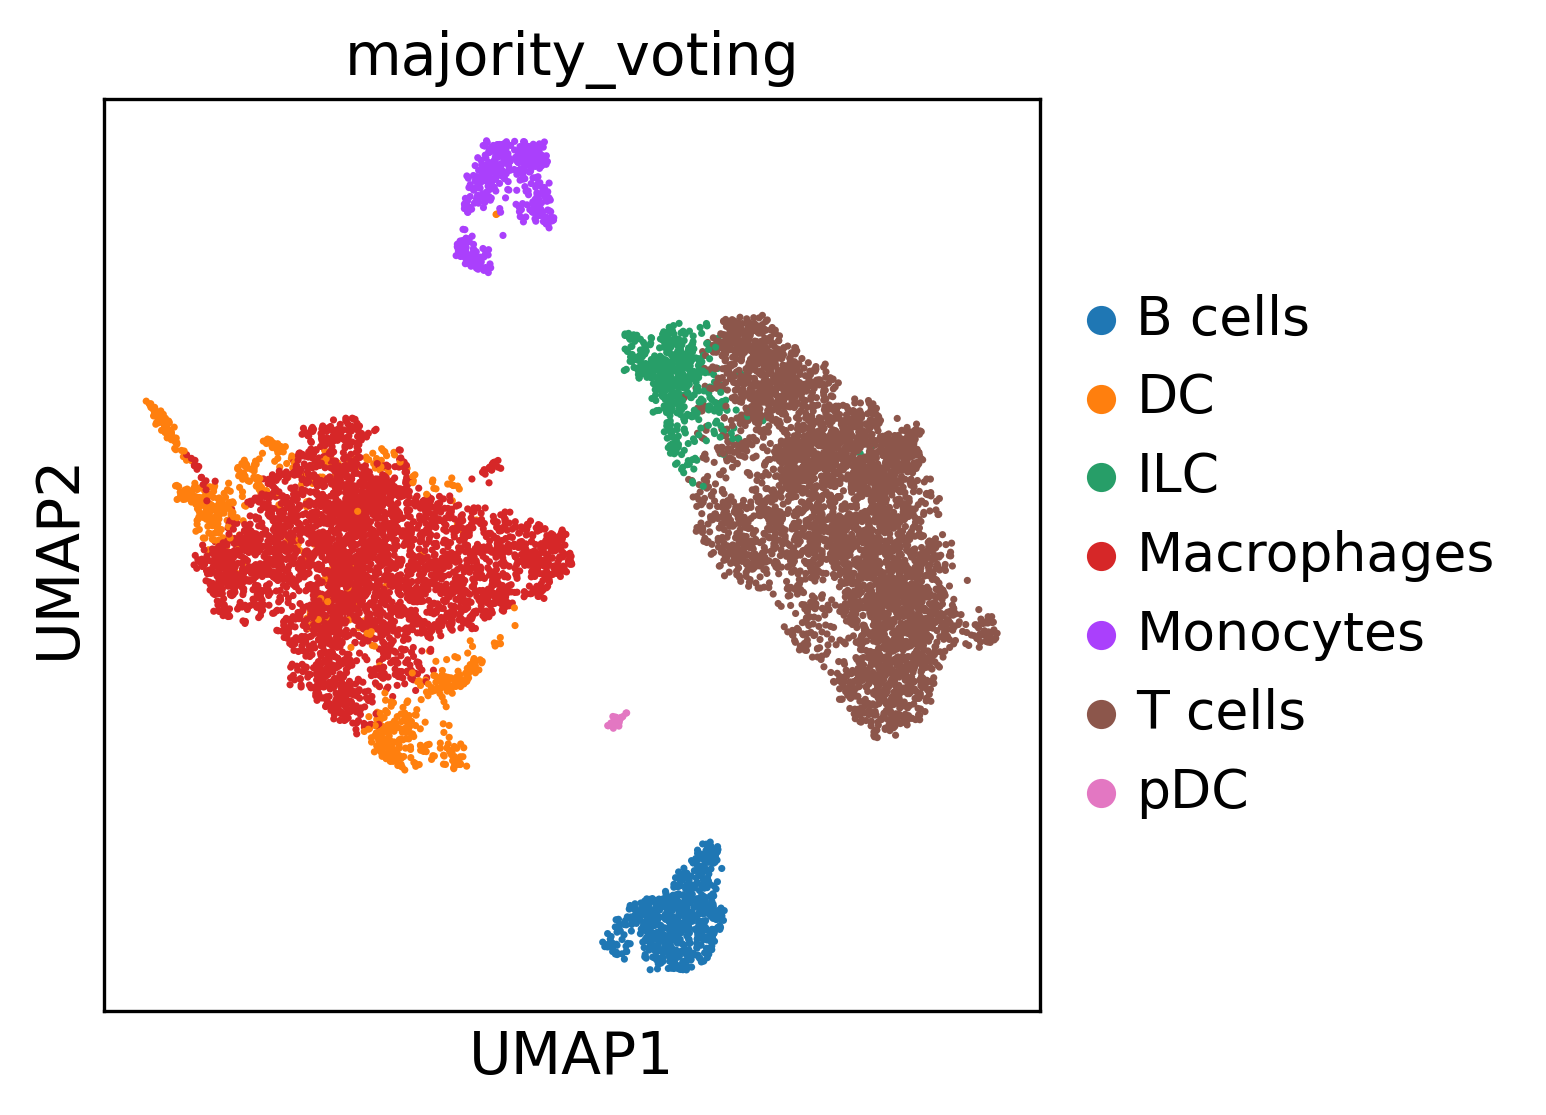

In [76]:
sc.set_figure_params(dpi=150)
sc.pl.umap(predictionsHigh.to_adata(), color='majority_voting')

# PanglaoDB classification

In [77]:
adata = adata[:, adata.var.highly_variable]

In [78]:
markers = dc.get_resource('PanglaoDB')
markers

label genesymbol canonical_marker         cell_type germ_layer human  \
0          CTRB1            False       Enterocytes   Endoderm  True   
1          CTRB1             True      Acinar cells   Endoderm  True   
2           KLK1             True      Acinar cells   Endoderm  True   
3           KLK1            False      Goblet cells   Endoderm  True   
4           KLK1            False  Epithelial cells   Mesoderm  True   
...          ...              ...               ...        ...   ...   
8472     SLC14A1             True  Urothelial cells   Mesoderm  True   
8473       UPK3A             True  Urothelial cells   Mesoderm  True   
8474       UPK1A             True  Urothelial cells   Mesoderm  True   
8475        UPK2             True  Urothelial cells   Mesoderm  True   
8476       UPK3B             True  Urothelial cells   Mesoderm  True   

label human_sensitivity human_specificity mouse mouse_sensitivity  \
0                   0.0        0.00439422  True        0.00331126   
1                   1.0       0.000628931  True          0.957143   
2              0.833333        0.00503145  True          0.314286   
3              0.588235        0.00503937  True          0.903226   
4                   0.0        0.00823306  True          0.225806   
...                 ...               ...   ...               ...   
8472                0.0         0.0181704  True               0.0   
8473                0.0               0.0  True               0.0   
8474                0.0               0.0  True               0.0   
8475                0.0               0.0  True               0.0   
8476                0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0             0.0204803        9606         GI tract           0.017  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
3             0.0124084        9606         GI tract           0.013  
4             0.0137585        9606       Epithelium           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[8477 rows x 13 columns]

In [ ]:
markers['organ'].value_counts()

In [79]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label genesymbol canonical_marker                     cell_type germ_layer  \
1          CTRB1             True                  Acinar cells   Endoderm   
2           KLK1             True                  Acinar cells   Endoderm   
5           KLK1             True               Principal cells   Mesoderm   
7           KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
8           KLK1             True             Endothelial cells   Mesoderm   
...          ...              ...                           ...        ...   
8472     SLC14A1             True              Urothelial cells   Mesoderm   
8473       UPK3A             True              Urothelial cells   Mesoderm   
8474       UPK1A             True              Urothelial cells   Mesoderm   
8475        UPK2             True              Urothelial cells   Mesoderm   
8476       UPK3B             True              Urothelial cells   Mesoderm   

label human human_sensitivity human_specificity mouse mouse_sensitivity  \
1      True               1.0       0.000628931  True          0.957143   
2      True          0.833333        0.00503145  True          0.314286   
5      True               0.0        0.00814536  True          0.285714   
7      True               0.0        0.00820189  True               1.0   
8      True               0.0        0.00841969  True               0.0   
...     ...               ...               ...   ...               ...   
8472   True               0.0         0.0181704  True               0.0   
8473   True               0.0               0.0  True               0.0   
8474   True               0.0               0.0  True               0.0   
8475   True               0.0               0.0  True               0.0   
8476   True               0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
5             0.0140583        9606           Kidney           0.013  
7             0.0129136        9606    Immune system           0.013  
8             0.0149153        9606      Vasculature           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [80]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

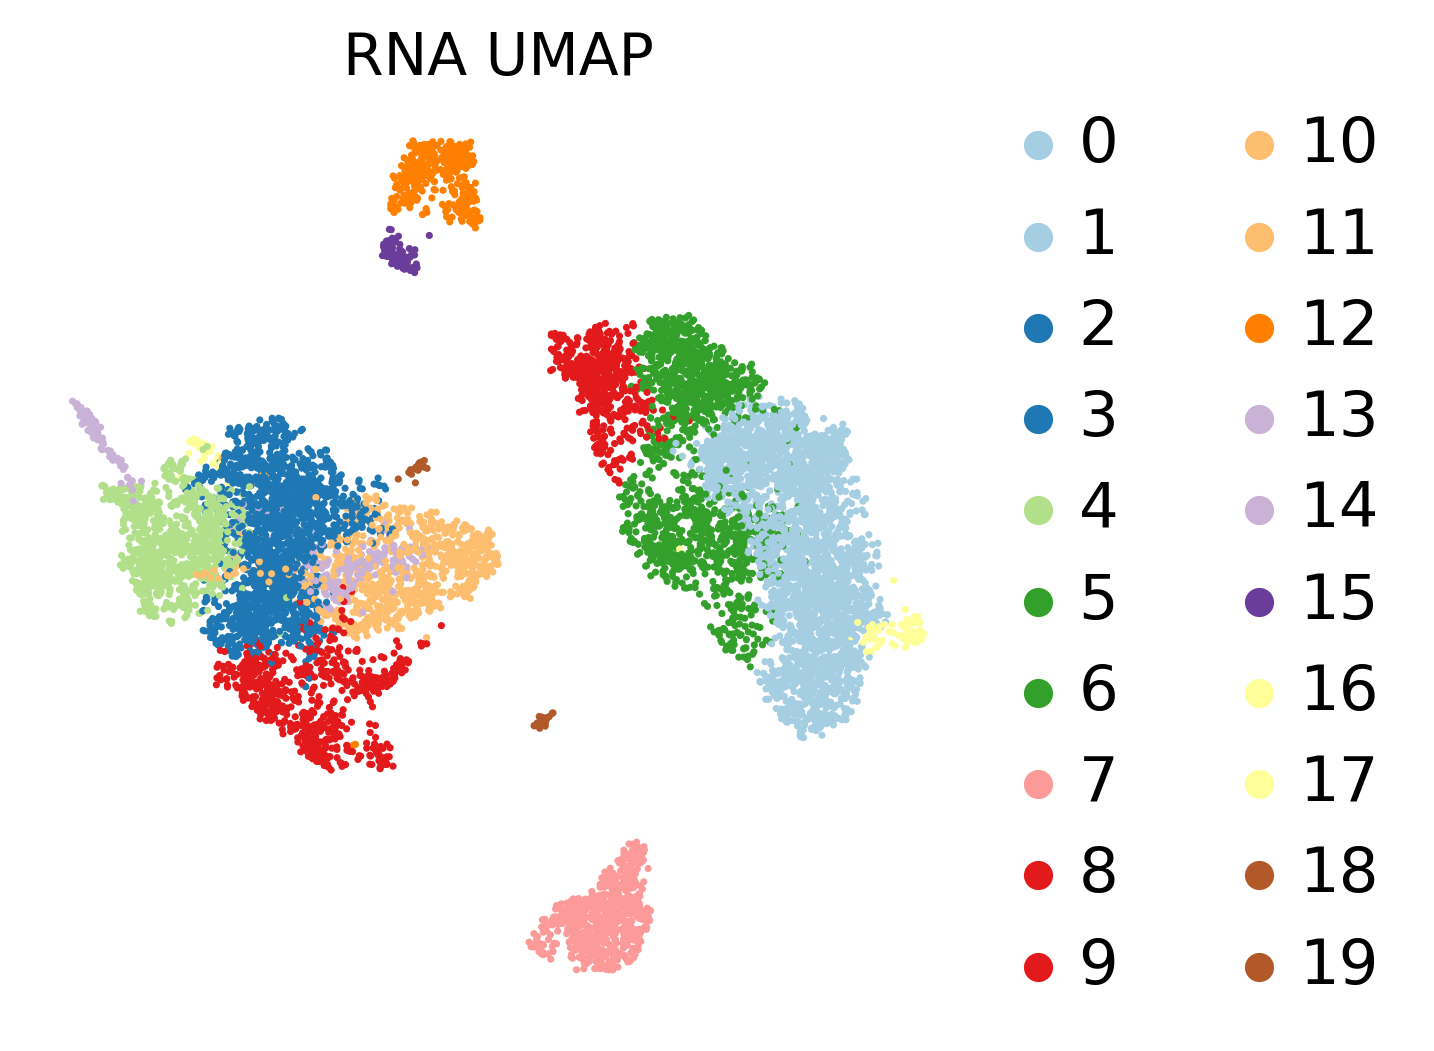

In [81]:
# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',palette='Paired',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [82]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

Running ora on mat with 10220 samples and 6628 targets for 108 sources.


100%|██████████| 10220/10220 [00:04<00:00, 2319.01it/s]


In [83]:
adata.obsm['ora_estimate']

source       Acinar cells  Adipocytes  Airway goblet cells  Alpha cells  \
ctrl085_L-0     -0.000000    1.879060            -0.000000     0.901855   
ctrl085_L-1      3.169078    1.879060             1.095298    -0.000000   
ctrl085_L-2     -0.000000    5.071393            -0.000000     0.901855   
ctrl085_L-3     -0.000000    1.879060            -0.000000     0.901855   
ctrl085_L-4      4.648895    1.879060            -0.000000     0.901855   
...                   ...         ...                  ...          ...   
ctrl12-295      -0.000000    1.879060            -0.000000    -0.000000   
ctrl12-296       0.774140    0.403389            -0.000000     0.901855   
ctrl12-297      -0.000000    0.403389            -0.000000    -0.000000   
ctrl12-298      -0.000000    0.403389            -0.000000    -0.000000   
ctrl12-299       1.863711    7.646495            -0.000000    -0.000000   

source       Astrocytes   B cells  B cells memory  B cells naive  Basophils  \
ctrl085_L-0    1.408848  0.403389        0.812988       1.665446   1.292284   
ctrl085_L-1    0.564575  3.906886        1.490590       1.665446   0.511166   
ctrl085_L-2    1.408848  1.879060        1.490590       2.539222   1.292284   
ctrl085_L-3    1.408848  2.837654        2.294202       0.921315  -0.000000   
ctrl085_L-4   -0.000000  2.837654        3.201660       3.519779   1.292284   
...                 ...       ...             ...            ...        ...   
ctrl12-295     1.408848  1.054579        2.294202       1.665446   1.292284   
ctrl12-296     0.564575  0.403389        1.490590       0.343985  -0.000000   
ctrl12-297     1.408848  6.320501        3.201660       2.539222   2.257728   
ctrl12-298     0.564575  2.837654        4.197977       2.539222   2.257728   
ctrl12-299     2.442973  1.879060        0.812988       0.343985   0.511166   

source       Bergmann glia  ...  Smooth muscle cells    T cells  \
ctrl085_L-0       0.679903  ...             1.731652   0.343985   
ctrl085_L-1      -0.000000  ...             2.631797   2.539222   
ctrl085_L-2       1.659246  ...             4.740608   0.343985   
ctrl085_L-3       0.679903  ...             1.731652   0.343985   
ctrl085_L-4       0.679903  ...             0.962525   1.665446   
...                    ...  ...                  ...        ...   
ctrl12-295       -0.000000  ...             0.362256  18.901581   
ctrl12-296        0.679903  ...             0.362256   0.921315   
ctrl12-297       -0.000000  ...             0.362256  12.502231   
ctrl12-298        0.679903  ...             0.362256  11.032497   
ctrl12-299        1.659246  ...            -0.000000   1.665446   

source       T follicular helper cells  T helper cells  T memory cells  \
ctrl085_L-0                  -0.000000        0.774140       -0.000000   
ctrl085_L-1                  -0.000000        0.774140        3.088755   
ctrl085_L-2                   1.309979        0.774140       -0.000000   
ctrl085_L-3                  -0.000000        1.863711        1.309979   
ctrl085_L-4                  -0.000000        0.774140        1.309979   
...                                ...             ...             ...   
ctrl12-295                   -0.000000        1.863711        1.309979   
ctrl12-296                   -0.000000       -0.000000        1.309979   
ctrl12-297                   -0.000000        0.774140        3.088755   
ctrl12-298                   -0.000000        1.863711        1.309979   
ctrl12-299                   -0.000000        0.774140        1.309979   

source       T regulatory cells  Tanycytes  Taste receptor cells  Thymocytes  \
ctrl085_L-0           -0.000000   0.901855             -0.000000    1.721462   
ctrl085_L-1            0.854242   0.901855             -0.000000    0.708598   
ctrl085_L-2           -0.000000  -0.000000              1.309979    2.940906   
ctrl085_L-3           -0.000000  -0.000000             -0.000000    0.708598   
ctrl085_L-4           -0.000000  -0.000000             -

In [84]:
adata.obsm['ora_estimate'].columns

Index(['Acinar cells', 'Adipocytes', 'Airway goblet cells', 'Alpha cells',
       'Astrocytes', 'B cells', 'B cells memory', 'B cells naive', 'Basophils',
       'Bergmann glia',
       ...
       'Smooth muscle cells', 'T cells', 'T follicular helper cells',
       'T helper cells', 'T memory cells', 'T regulatory cells', 'Tanycytes',
       'Taste receptor cells', 'Thymocytes', 'Tuft cells'],
      dtype='object', name='source', length=108)

In [85]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 10220 × 108
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'ora_estimate', 'ora_pvals'

In [86]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

Adipocytes   B cells  B cells memory  B cells naive  Dendritic cells  \
0     1.193605  2.701753        1.775573       1.640989         3.955623   
1     1.137346  1.939263        1.382847       0.896832         4.717680   
10    2.962265  1.182293        1.182462       0.755828         7.850910   
11    3.394489  1.245526        1.302407       0.869596         6.860425   
12    3.820833  1.339476        0.856043       0.720791        14.299163   
13    4.330517  1.087012        0.741942       0.600370         8.287626   
14    2.286691  0.944238        2.168679       0.665042         3.793476   
15    3.526881  1.724572        1.313202       0.651131        12.661777   
16    1.531839  2.131475        1.826450       1.245276         3.991308   
17    3.151963  1.110505        1.270222       1.013214         6.699597   
18    0.634311  2.234159        1.816713       1.812217         4.405524   
19    2.173776  0.800996        0.986058       0.382148         8.849624   
2     2.758470  0.845640        0.661218       0.636795         6.609407   
3     3.142983  1.172897        0.791493       0.762988         9.252323   
4     2.473573  1.216653        1.156815       0.746168         6.515187   
5     1.116172  1.732350        1.581889       1.083968         4.326460   
6     1.184732  1.430555        1.043711       0.493883         4.036477   
7     0.882198  9.268349        9.991714       8.171239         5.272022   
8     2.202592  1.858182        1.657556       1.219252        12.052436   
9     1.147912  1.437880        1.272746       0.632917         4.642766   

    Endothelial cells  Gamma delta T cells  Kupffer cells  Macrophages  \
0            1.376268             1.690364       0.456316     0.994588   
1            1.157284             5.063489       0.857640     1.828253   
10           2.938070             0.320086       7.866483    11.534686   
11           2.420296             0.387147       7.431383    10.741289   
12           2.845699             0.314875       2.925918     8.008502   
13           3.126520             0.277200       7.054124    10.795371   
14           1.656624             0.386416       2.585339     5.272522   
15           2.236885             0.531085       2.381654     7.598951   
16           1.522744             1.643491       0.774474     1.550720   
17           3.066290             0.268125       6.528161    12.468777   
18           1.750481             1.868526       0.669924     1.924679   
19           2.462327             0.828656       8.534792     7.383163   
2            4.630709             0.336602       7.215014    11.056522   
3            5.261071             0.390296       8.973352    12.913383   
4            3.606043             0.318574       5.542655    10.327771   
5            1.232637             3.684975       0.954149     1.626897   
6            1.030448            11.591694       0.651074     2.042450   
7            1.194181             0.362288       0.500577     1.459666   
8            2.626453             0.580128       5.158554     8.741353   
9            1.039680            14.875411       1.057086     2.159096   

    Microglia  Monocytes   NK cells  Natural killer T cells  Neutrophils  \
0    0.851095   2.198675   3.013180                2.283798     0.616191   
1    1.137800   2.368014   8.695280                2.935908     0.495980   
10   7.089328   6.170177   0.822124                1.716342     2.597049   
11   7.170101   5.280685   0.602390                1.248947     1.622185   
12   5.327176  11.570278   0.568258                0.849114     9.100373   
13   5.947908   5.059066   0.588804                1.123613     3.421001   
14   8.162632   2.985767   0.382482                1.130218     0.882356   
15   4.805832   9.257961   1.532764                1.100239     5.323982   
16   1.428456   2.935162   3.054343                2.452578     0.767174   
17   6.797295   5.819616   0.887987                1.533280     2.375357   
18   1.369417   

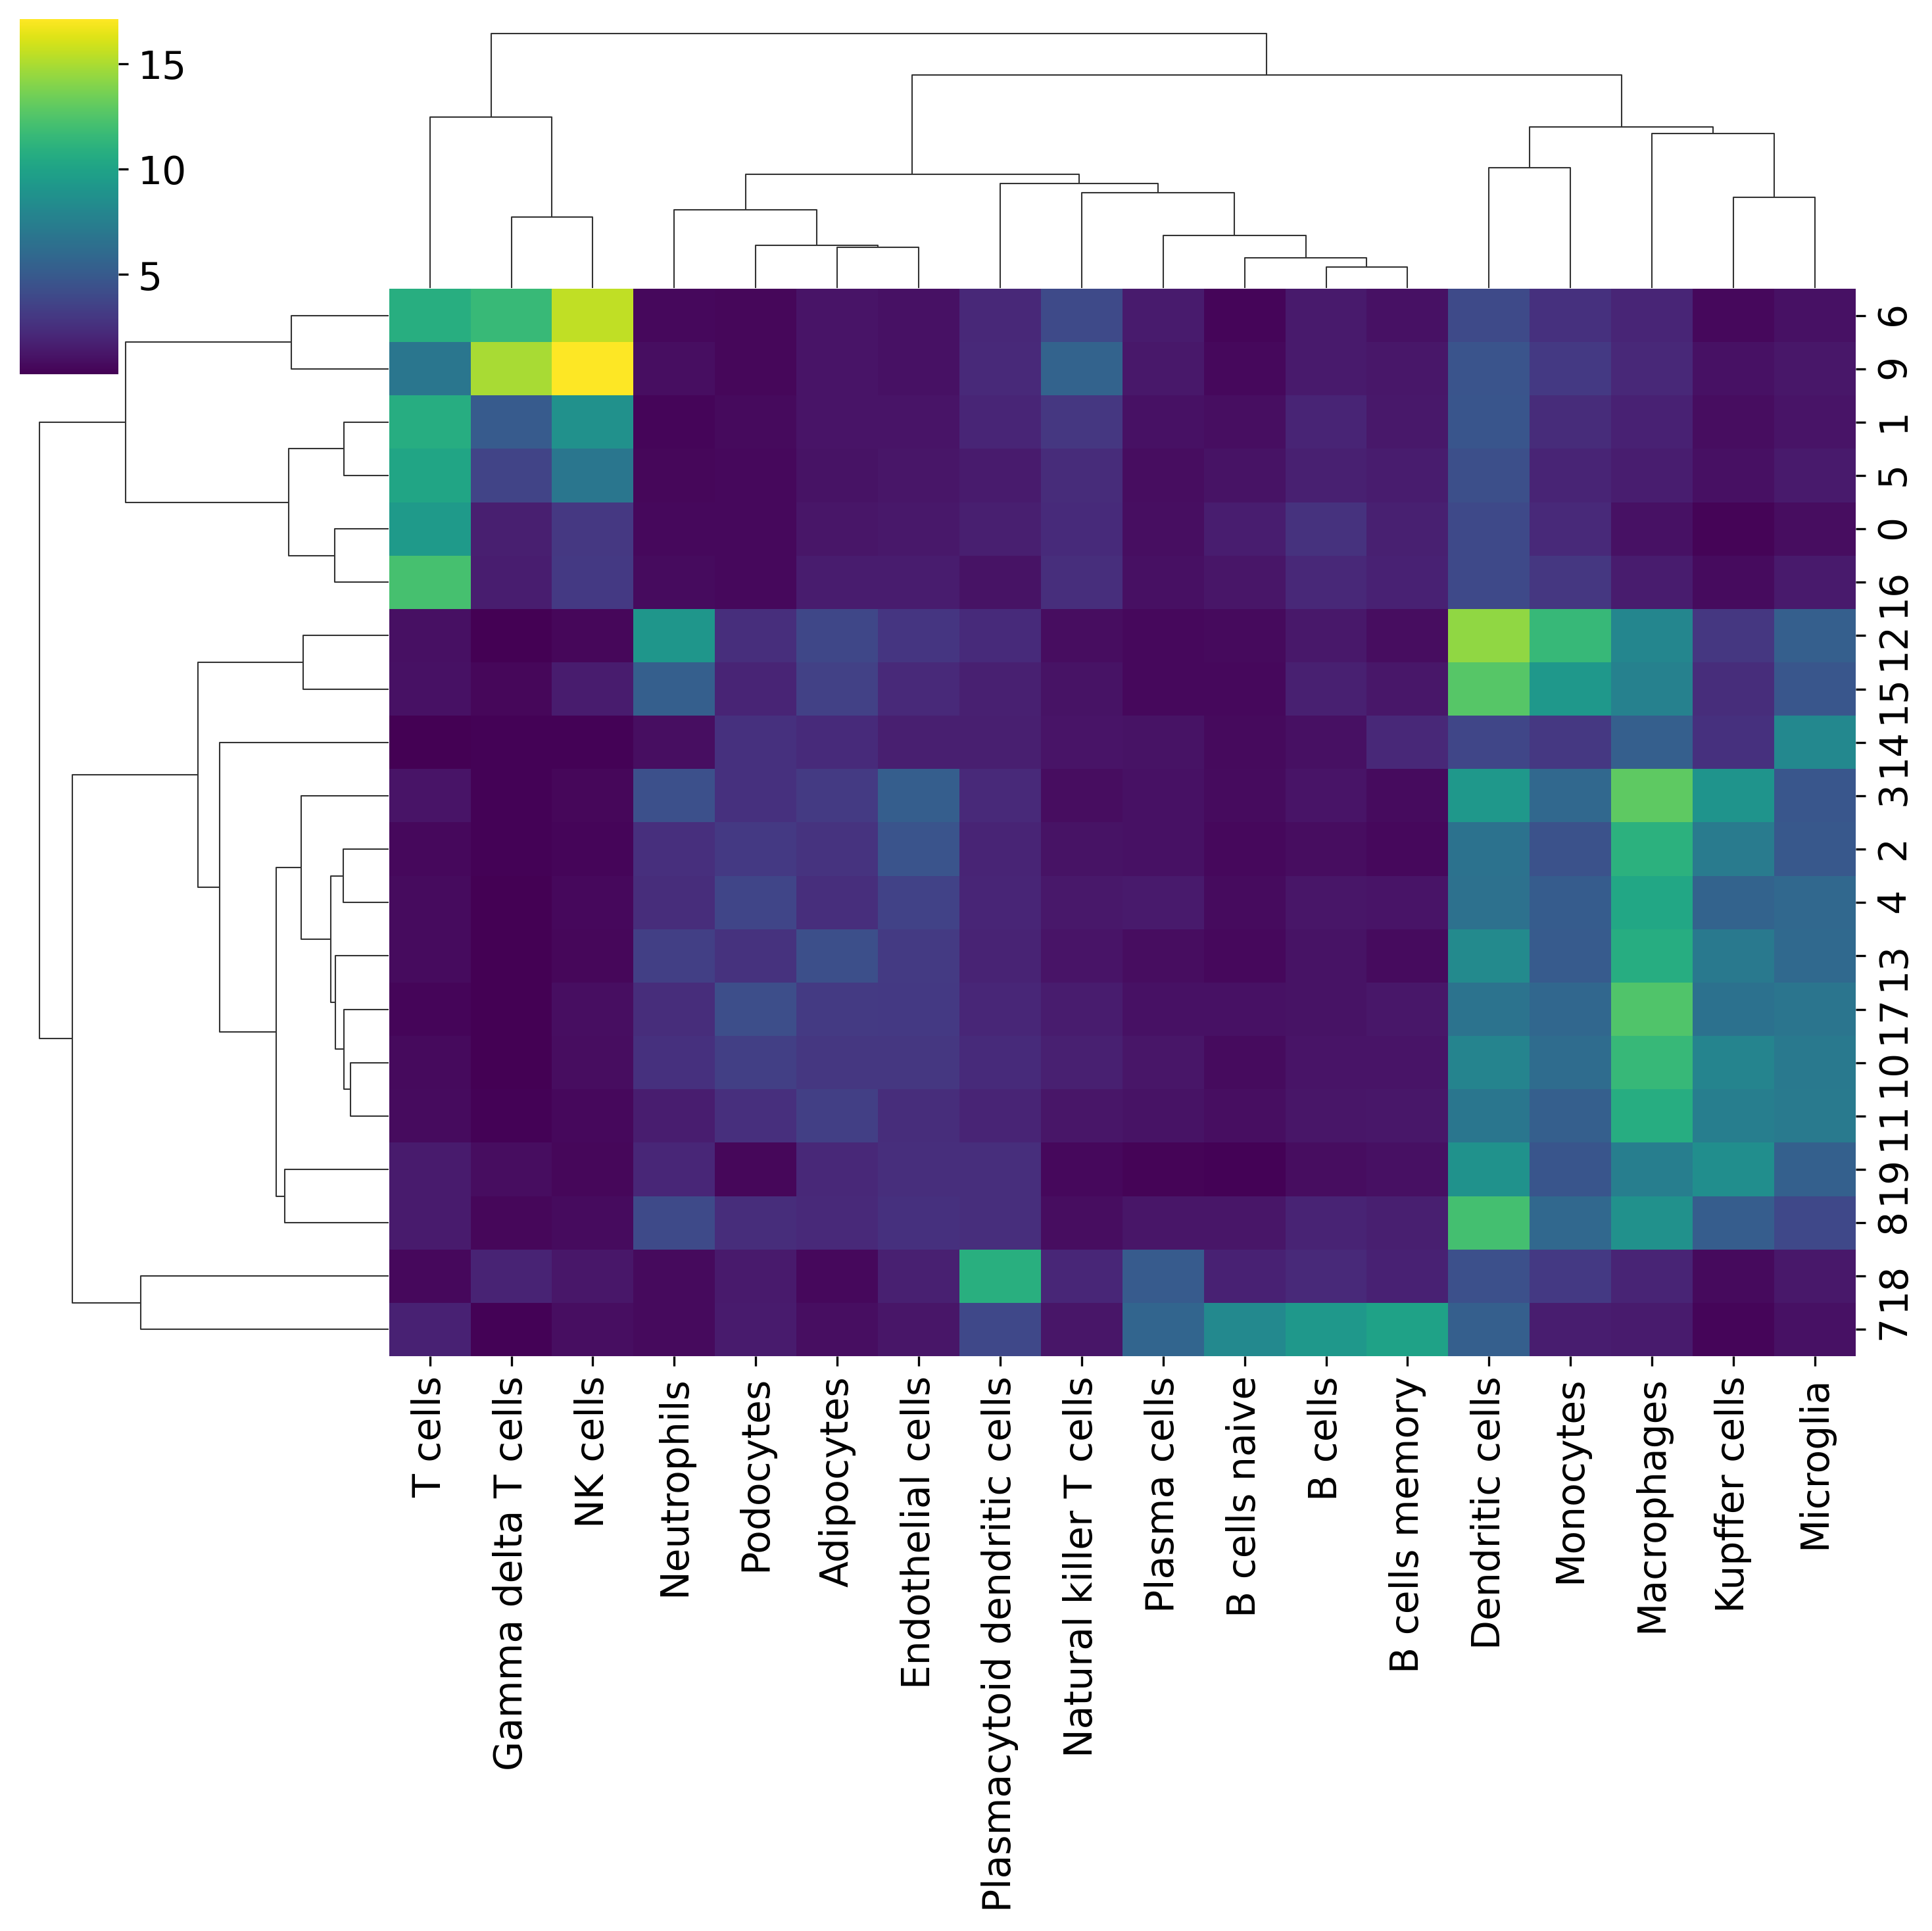

In [87]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In [88]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'T cells',
 '1': 'T cells',
 '10': 'Macrophages',
 '11': 'Macrophages',
 '12': 'Dendritic cells',
 '13': 'Macrophages',
 '14': 'Microglia',
 '15': 'Dendritic cells',
 '16': 'T cells',
 '17': 'Macrophages',
 '18': 'Plasmacytoid dendritic cells',
 '19': 'Dendritic cells',
 '2': 'Macrophages',
 '3': 'Macrophages',
 '4': 'Macrophages',
 '5': 'T cells',
 '6': 'NK cells',
 '7': 'B cells memory',
 '8': 'Dendritic cells',
 '9': 'NK cells'}

... storing 'cell_type' as categorical


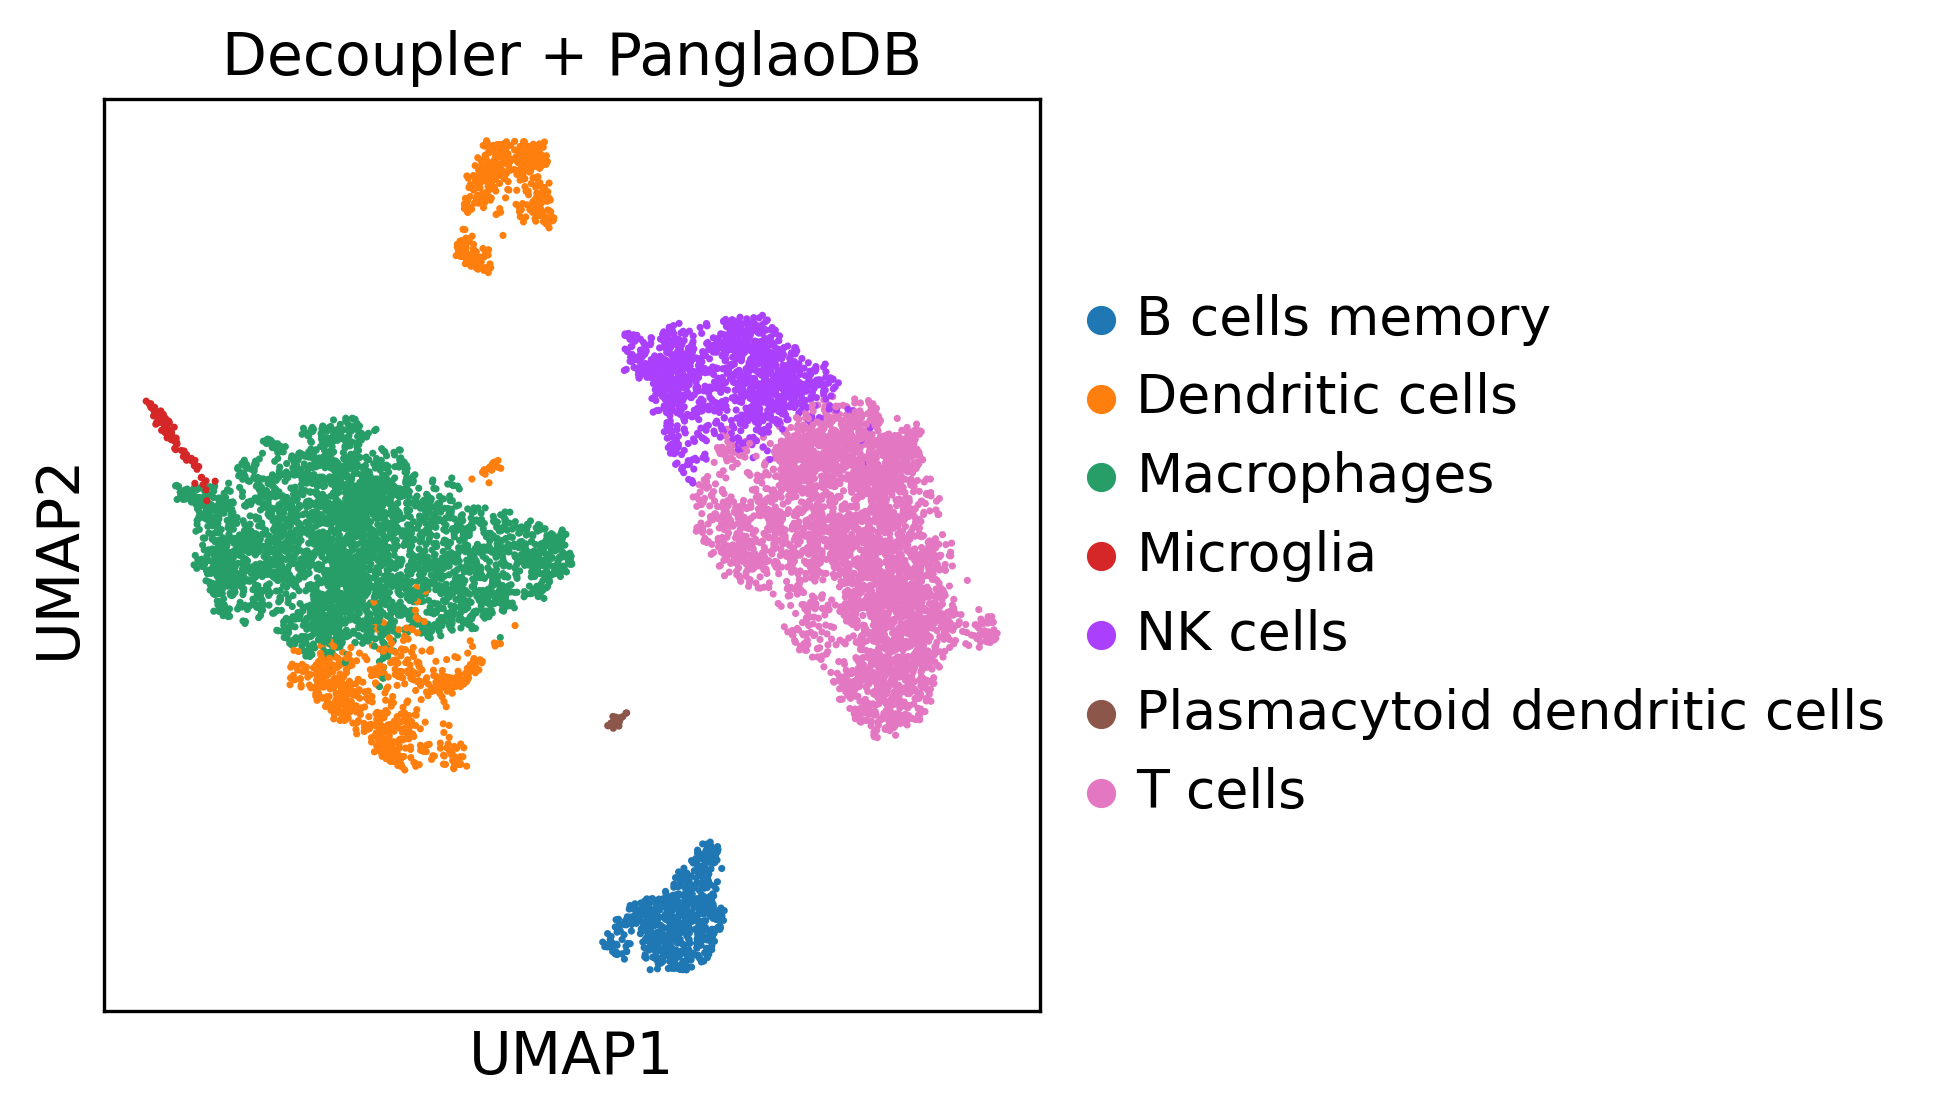

In [89]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type',title='Decoupler + PanglaoDB')

In [90]:
adata

AnnData object with n_obs × n_vars = 10220 × 6628
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X

In [91]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_I_Winkler.h5ad")